In [1]:
import torch
print(torch.__version__)
from math import log

2.1.1+cpu


In [2]:
D = 4
H = 8
R0 = 0.1
hidden_size = 100

In [3]:
def right_state(state):
    global H, D
    res = []
    for i in range(0, D):
        for j in range(0, H):
            res.append(float(0) + (state[i] == j))
    return res

In [4]:
def reward(x):
    global R0, D, H
    f1 = True
    f2 = True
    for d in range(D):
        if not (0.25 < abs(x[d] / (H - 1) - 0.5) <= 0.5): f1 = False
        if not (0.3 < abs(x[d] / (H - 1) - 0.5) < 0.4): f2 = False
    return (R0 + 0.5 * f1 + 2 * f2)

In [5]:
from collections import OrderedDict

modelDB = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, D + 2))
    ])
)

optimizerDB = torch.optim.SGD(
    modelDB.parameters(),  # Передаём все тензоры, учавствующие в градиентном спуске
    lr=0.01,  # learning rate - величина шага градиентного спуска
)

modelTB = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, D + 1))
    ])
)
log_Z = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True))
log_Z_optimizer = torch.optim.Adam([log_Z], 0.01)

optimizerTB = torch.optim.SGD(
    modelTB.parameters(),  # Передаём все тензоры, учавствующие в градиентном спуске
    lr=0.01,  # learning rate - величина шага градиентного спуска
)

In [6]:
def trajectory_balance():
    global H, D, log_Z
    state = [0] * D
    way = []
    while True:
        pred = modelTB(torch.tensor(right_state(state)))
        p_Fs = pred
        p_B = 0
        for i in range(0, D):
            if state[i] == H - 1:
                p_Fs[i] = -float("inf")
            if state[i] > 0:
                p_B += 1
        m = torch.nn.Softmax(dim=0)
        p_Fs = m(p_Fs)
        ind = torch.distributions.categorical.Categorical(p_Fs).sample()
        p_B = max(p_B, 1)
        way.append([torch.log(p_Fs[ind]), 1 / p_B])
        if ind == D:
            way.append([0, 1])
            break
        state[ind] += 1
    loss = log_Z - log(reward(state))
    for i in range(0, len(way) - 1):
        loss += way[i][0] - log(way[i + 1][1])
    loss = loss ** 2
    return loss, state

In [7]:
from itertools import product

rewards = torch.zeros(*[H for i in range(D)])
coord_diap = [range(H) for _ in range(D)]

for coord in product(*coord_diap):
    rewards[tuple(coord)] = reward(torch.tensor(coord))

rewards /= rewards.sum()

def metric(a, samples=1000):
    counter = torch.zeros(*[H for i in range(D)])
    for i in range(samples):
        counter[tuple(a[i])] += 1

    counter /= counter.sum()

    return (rewards - counter).abs().sum()

In [8]:
def right_state(state):
    global H, D
    res = []
    for i in range(0, D):
        for j in range(0, H):
            res.append(float(0) + (state[i] == j))
    return res

In [9]:
def detailed_balance():
    global H, D
    state = [0] * D
    way = []
    while True:
        pred = modelDB(torch.tensor(right_state(state)))
        p_Fs = pred[0:-1]
        F = pred[-1]
        p_B = 0
        for i in range(0, D):
            if state[i] == H - 1:
                p_Fs[i] = -float("inf")
            if state[i] > 0:
                p_B += 1
        m = torch.nn.Softmax(dim=0)
        p_Fs = m(p_Fs)
        ind = torch.distributions.categorical.Categorical(p_Fs).sample()
        p_B = max(p_B, 1)
        way.append([F, torch.log(p_Fs[ind]), 1 / p_B])
        if ind == D:
            break
        state[ind] += 1
    loss = 0
    for i in range(0, len(way) - 1):
        loss += (way[i][0] + way[i][1] - way[i+1][0] - log(way[i + 1][2])) ** 2
    loss += (way[-1][0] + way[-1][1] - log(reward(state)) - log(1)) ** 2
    return loss, state

In [10]:
def calcDB(optimizer):
    optimizer.zero_grad()
    x = detailed_balance()
    loss = x[0]
    smpl = x[1]
    loss.backward()
    optimizer.step()
    return smpl

def calcTB(optimizer):
    optimizer.zero_grad()
    log_Z_optimizer.zero_grad()
    x = trajectory_balance()
    loss = x[0]
    smpl = x[1]
    loss.backward()
    log_Z_optimizer.step()
    optimizer.step()
    return smpl
    

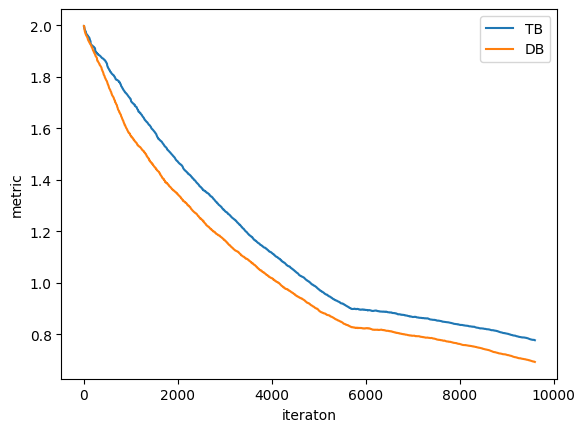

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [11]:
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

db = []
tb = []

trajectory_balance_mem = []
detailed_balance_mem = []

plt.ion()

for i in range(0, 20000):
    db.append(calcDB(optimizerDB))
    tb.append(calcTB(optimizerTB))
    detailed_balance_mem.append(metric(db[-10000:], len(db[-10000:])))
    trajectory_balance_mem.append(metric(tb[-10000:], len(tb[-10000:])))
    if i % 200 == 0:
        clear_output(wait=True)
        plt.plot(trajectory_balance_mem)
        plt.plot(detailed_balance_mem)
        plt.legend(['TB', 'DB'])
        plt.xlabel('iteraton')
        plt.ylabel('metric')
        plt.draw()
        plt.pause(0.001)
        plt.clf()